In [2]:
import datetime as dt
import time
import pandas as pd

In [3]:
data_final = dt.datetime.now()
umano = dt.timedelta(days=1030)
data_inicial = data_final - umano
ticker = '%5EGSPC'
period1 = int(time.mktime(data_inicial.timetuple()))
period2 = int(time.mktime(data_final.timetuple()))
query_string =f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval=1d&events=history&includeAdjustedClose=true"

In [4]:
df = pd.read_csv(query_string)
print(df)

           Date         Open         High          Low        Close  \
0    2021-01-04  3764.610107  3769.989990  3662.709961  3700.649902   
1    2021-01-05  3698.020020  3737.830078  3695.070068  3726.860107   
2    2021-01-06  3712.199951  3783.040039  3705.340088  3748.139893   
3    2021-01-07  3764.709961  3811.550049  3764.709961  3803.790039   
4    2021-01-08  3815.050049  3826.689941  3783.600098  3824.679932   
..          ...          ...          ...          ...          ...   
706  2023-10-24  4235.790039  4259.379883  4219.430176  4247.680176   
707  2023-10-25  4232.419922  4232.419922  4181.419922  4186.770020   
708  2023-10-26  4175.990234  4183.600098  4127.899902  4137.229980   
709  2023-10-27  4152.930176  4156.700195  4103.779785  4117.370117   
710  2023-10-30  4139.390137  4177.470215  4132.939941  4166.819824   

       Adj Close      Volume  
0    3700.649902  5015000000  
1    3726.860107  4591020000  
2    3748.139893  6064110000  
3    3803.790039  50991

In [5]:
df_final = df.filter(items = ['Date', 'Close', 'Volume'])
df_final['Preço'] = df_final['Close']
df_final['MA7'] = df_final['Close'].rolling(7).mean()
df_final['MA25'] = df_final['Close'].rolling(25).mean()
df_final['NumTransacoes'] = df_final['Volume']
del df_final['Close']
del df_final['Volume']
df_final.columns.values

array(['Date', 'Preço', 'MA7', 'MA25', 'NumTransacoes'], dtype=object)

In [6]:
df_final.head()

,Date,Preço,MA7,MA25,NumTransacoes
0,2021-01-04,3700.649902,NaN,NaN,5015000000
1,2021-01-05,3726.860107,NaN,NaN,4591020000
2,2021-01-06,3748.139893,NaN,NaN,6064110000
3,2021-01-07,3803.790039,NaN,NaN,5099160000
4,2021-01-08,3824.679932,NaN,NaN,4773040000


In [7]:
import matplotlib.pyplot as plt
df = df_final 
df['Date'] = pd.to_datetime(df['Date'])
df.loc[24:]
df = df.loc[24:]

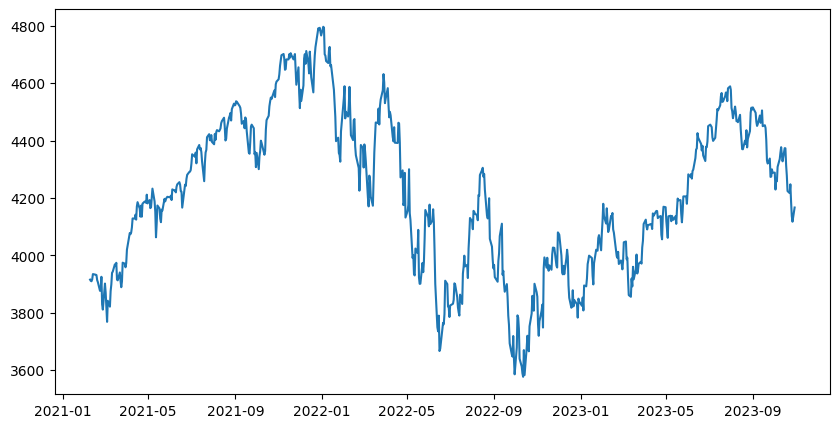

In [8]:
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Preço'], label='S&P 500')
plt.show()

In [9]:
gspc_treino, gspc_teste = df[0:int(len(df)*0.7)], df[int(len(df)*0.3):]

In [10]:
gspc_teste.head()

,Date,Preço,MA7,MA25,NumTransacoes
230,2021-12-01,4513.040039,4629.290039,4651.265586,5366730000
231,2021-12-02,4577.100098,4614.170061,4652.282383,5077180000
232,2021-12-03,4538.430176,4592.417202,4649.962793,5240070000
233,2021-12-06,4591.669922,4576.732910,4649.414395,4770800000
234,2021-12-07,4686.750000,4589.894322,4652.337598,4492400000


In [11]:
gspc_treino.to_csv('gspc_treino.csv', index=False)
gspc_teste.to_csv('gspc_teste.csv', index=False)

In [12]:
def carrega(caminho):
    dados = pd.read_csv(caminho)
    dados.sort_values(by=['Date'])
    del dados['Dados']
    return dados

In [13]:
from sklearn.preprocessing import MinMaxScaler
import joblib
import os

def normaliza(dados):
    nome_normalizador = 'normalizador.joblib.pkl'
    # caso ainda não exista
    if not os.path.isfile(nome_normalizador):
        # inicializa-se com a função MixMaxScaler
        normalizador = MinMaxScaler(feature_range=(0, 1))
        # usa a função fit_transform para mudar o normalizador
        dados_normalizados = normalizador.fit_transoform(dados)
        joblib.dump(normalizador, nome_normalizador)
    else: # se jã existe, carrega-o em memória e transforma 
        # os dados são somente aplicados ao transform
        normalizador = joblib.load(nome_normalizador)
        dados_normalizados = normalizador.transform(dados)
    return dados_normalizados


In [14]:
import numpy as np

def prepara(dados, coluna_esperada, historico):
    entr_normal = normaliza(dados)
    # guarda os dados esperados em memória
    p_esp = dados.columns.get_loc(coluna_esperada)
    dados_esperados = entr_normal[:, p_esp:p_esp+1]
    # ignora os primeiros dados (sem histórico)
    dados_esperados = dados_esperados[historico:, :]
    # aqui é montado o vetor de entrada da LSTM
    # onde cada posição contém os parâmetros normalizados
    # dos minutos anterios à i
    dados_treino = []
    for i in range(historico, len(entr_normal)):
        dados_treino.append(entr_normal[i-historico:i, :])
    # transforma todos em arrays com numpy 
    dados_treino = np.array(dados_treino)
    dados_esperados = np.array(dados_esperados)
    return [dados_treino, dados_esperados]

In [15]:
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense

def cria_modelo(historico, parametros):
    modelo = Sequential()
    modelo.add(LSTM(units=100, return_sequences=True, input_shape=(historico, parametros)))
    modelo.add(Dropout(0.3))
    modelo.add(LSTM(units=50, return_sequences=True))
    modelo.add(Dropout(0.3))
    modelo.add(LSTM(units=50))
    modelo.add(Dropout(0.3))
    modelo.add(Dense(units=1))
    modelo.compile(optimizer='adam', loss='mean_squared_error')
    return modelo

ModuleNotFoundError: No module named 'tensorflow'

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def treina(modelo, data_train, dados_esp, epochs=100):
    es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
    rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1)
    mcp = ModelCheckpoint(filepath='pesos.h5', monitor='loss', save_best_only=True, verbose=1)
    # treina o modelo
    modelo.fit(data_train, dados_esp, callbacks=[es, rlr, mcp], batch_size=32, epochs=epochs)

ModuleNotFoundError: No module named 'tensorflow'

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates

def testa(modelo, caminho, hist, parametros, datas):
    if isinstance(modelo, str):
        temp = cria_modelo(hist, parametros)
        temp.load_weights(modelo)
        modelo = temp

    dados = carrega(caminho)
    dados_teste, dados_esp = prepara(dados, 'Preço', hist)
    previstos = modelo.predict(dados_teste)
    dados = np.array(dados)
    precos_reais = []
    # armazena preço real e substitui pela previsão
    for i in range(hist, len(dados)):
        precos_reais.append(dados[i, 0])
        dados[i, 0] = previstos[i-hist, 0]
    # ignora as primeiras linhas sem dados suficientes
    # para previsão
    dados = dados[hist:len(dados), :]
    caminho = 'normalizador.joblib.pkl'
    normalizador = joblib.load(caminho)
    # transforma os valores normalizados em vlrs reais
    dados_transf = normalizador.inverse_transform(dados)
    # seleciona apenas a coluna do preço
    precos_previstos = dados_transf[:, 0]
    fig, ax = plt.subplots()
    ax.plot(datas, precos_reais, label='Preço Real')
    